
# TIME SERIES OF MOTOR VEHICLE FATAL COLLISIONS  IN CANADA

The data for the motor vehicle collisions on public roads in Canada can be found at  the [National collision database](https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a).  It is a big data with more than 6 million observations. We have obtained the data for the year 1999 to 2016 and from it we've created a univariate time series data of the total monthly fatality. This notebook analyzes the data and makes forecast

# Imports

In [11]:
%matplotlib inline
# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

# Seaborn for data visualization
import seaborn as sns
# Set font scale and style
sns.set(font_scale = 2)
sns.set_style('ticks')
plt.style.use('seaborn-white')
mpl.rcParams['font.family'] = 'serif'

from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

# Load  data

In [13]:
ts = pd.read_csv('../data/collision_ts.csv')
ts.head()

,year,fatalities
0,1999-01,433
1,1999-02,482
2,1999-03,618
3,1999-04,438
4,1999-05,637


In [14]:
# convert to datetime
ts.year = pd.to_datetime(ts['year'])

In [15]:
# make date the dataframe index
ts.index = ts.year
ts =ts.drop(['year'], axis =1)

In [16]:
ts.head()

,fatalities
year,
1999-01-01,433
1999-02-01,482
1999-03-01,618
1999-04-01,438
1999-05-01,637


In [17]:
ts.shape # Dimension of the time series

(228, 1)

In [18]:
ts.isnull().sum() # Missing values

fatalities    0
dtype: int64

We see that there are no missing values in the time series data

## A. Time Series Plot

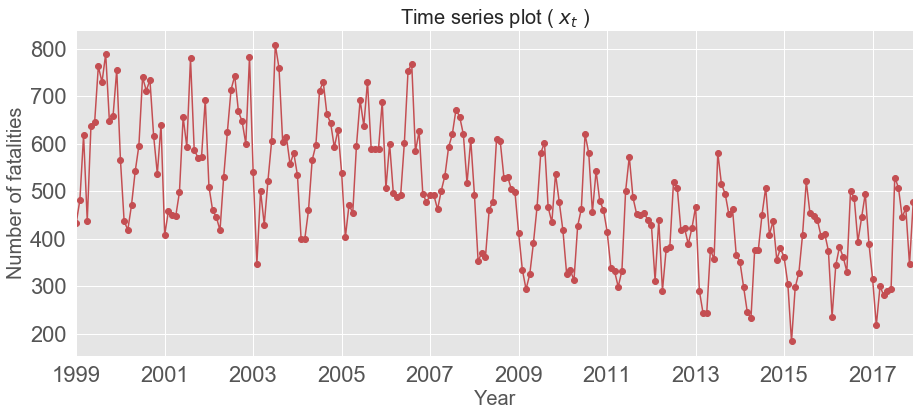

In [19]:
plot_timeseries(ts.fatalities, marker= 'o', color = 'r', title = 'Time series plot ( $x_t$ )')

## B. Stationarity Test ( Dickey-Fuller Test )

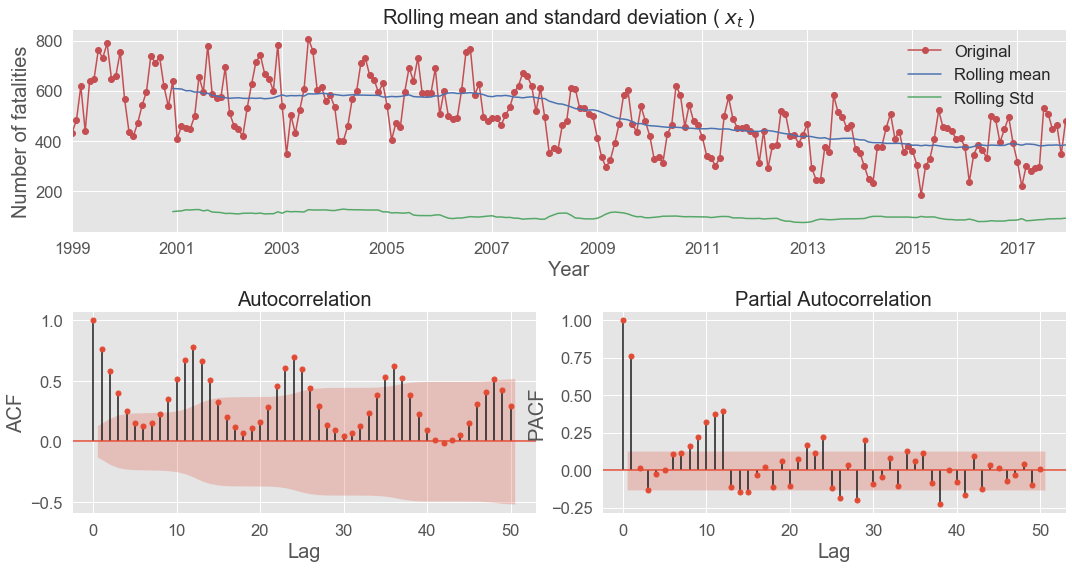

Test statistic: -1.0860821780674181
p-value: 0.7205901387315868
Critial Values (1%): -3.460992
Critial Values (5%): -2.875016
Critial Values (10%): -2.573952


In [20]:
plot_ts(ts.fatalities, title = 'Rolling mean and standard deviation ( $x_t$ )', nlags = 50)

We see that the time series is non-stationary,  because the null hypothesis cannot be rejected as the test statistic is greater than the critical values and the p-value is greater than 0.05. Another way to test for the stationarity of a time series is to plot the autocorrelation function (ACF). For a nonstationary time series the ACF will not decay quickly, whereas for a stationary time series the ACF  decays exponentially to 0 as lag increases.  The plot of ACF above shows that the time series is non-stationary.

## C. Log transformation

In [21]:
ts['fatalities_log'] = np.log(ts['fatalities'])

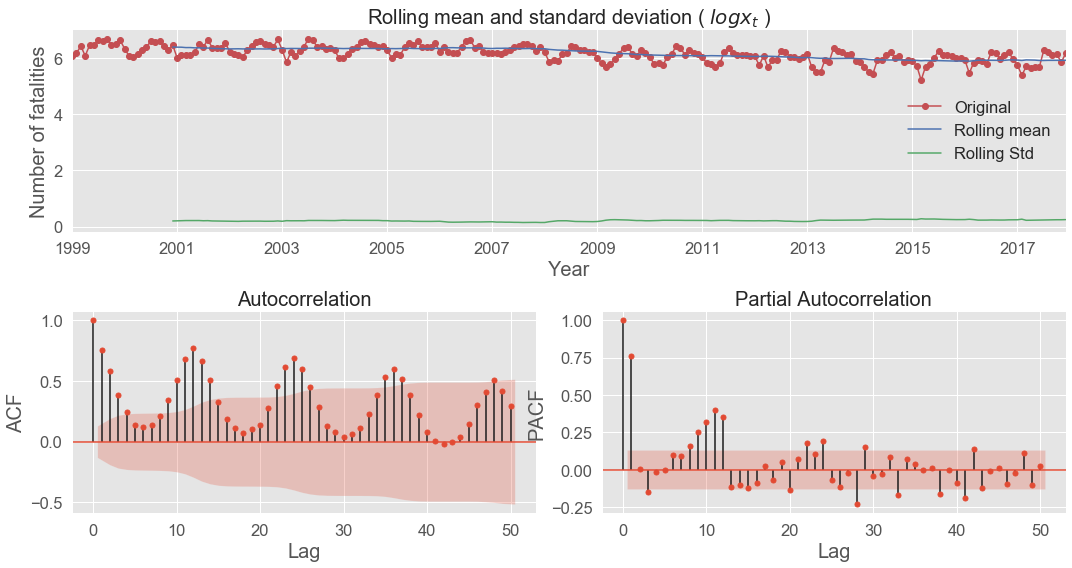

Test statistic: -0.6638979577128773
p-value: 0.8558805194677224
Critial Values (1%): -3.460992
Critial Values (5%): -2.875016
Critial Values (10%): -2.573952


In [22]:
plot_ts(ts.fatalities_log,  title = 'Rolling mean and standard deviation ( $log x_t$ )',nlags = 50)

We have checked that the log transformed data is still non-stantionary

## D. Seasonality of Log Transformed Data

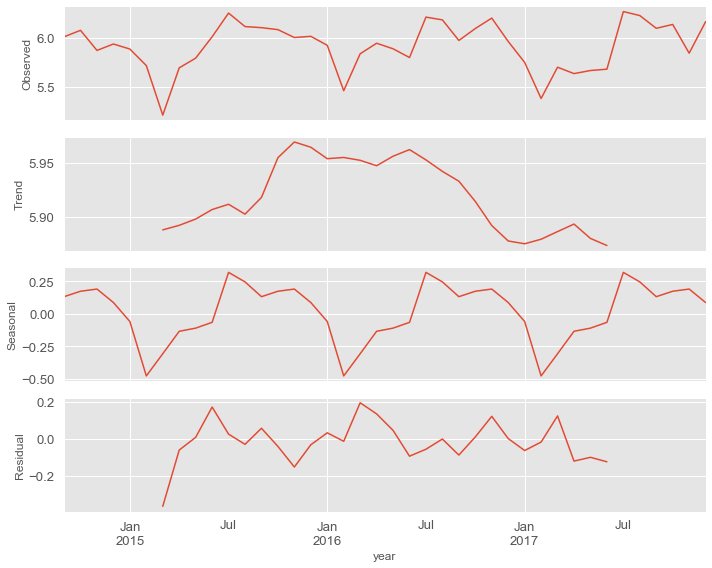

In [23]:
rcParams['figure.figsize'] = 10, 8
plt.rcParams.update({'font.size':40})
sns.set(font_scale = 1.2)
plt.style.use('ggplot')

decomposition = seasonal_decompose(ts.fatalities_log[-40:], model='additive')
decomposition.plot()
plt.show()

We have strong monthly seasonality as noted above

## E. Regular Differencing of Log Transformed Data

Differencing is one of the common methods for transforming a non-stationary time series to a  (weakly) stationary one. The first difference of a nonstationary time series  is a new time series which may be stationary. First, we take the log transformation of the time series and apply the first difference on the log transformed series

In [24]:
ts['fatalities_log_diff'] = ts['fatalities_log'] - ts['fatalities_log'].shift(1) # Apply first difference

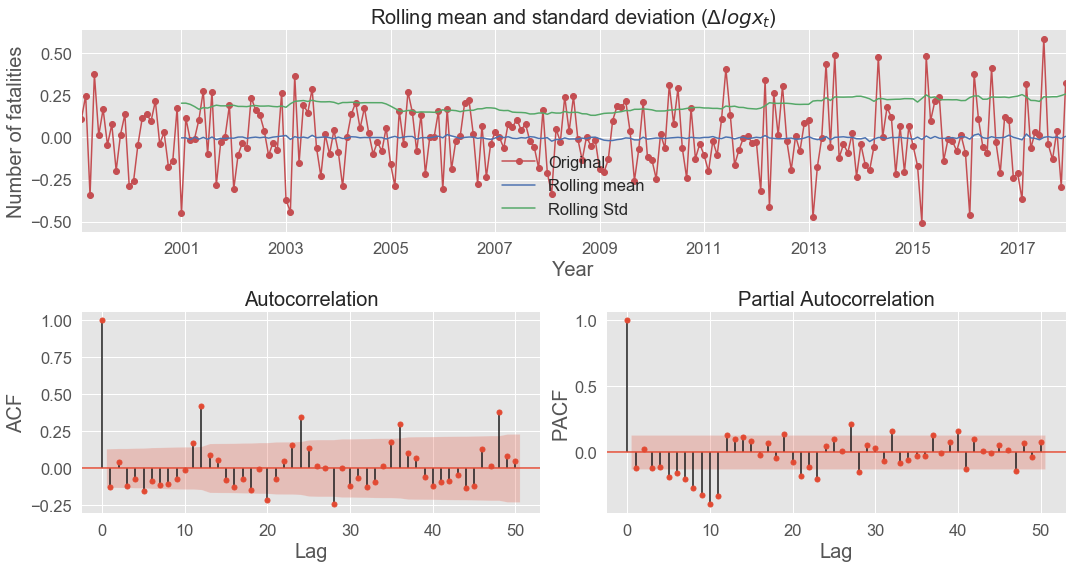

Test statistic: -17.306696757561912
p-value: 5.5863002106077774e-30
Critial Values (1%): -3.460992
Critial Values (5%): -2.875016
Critial Values (10%): -2.573952


In [25]:
plot_ts(ts.fatalities_log_diff.dropna(),  title = 'Rolling mean and standard deviation ($\Delta log x_t$)',
        nlags = 50)

We see that the test statistic is signicantly less than 1$\%$ critical value  and the p-value is less than 0.05. Therefore, the time series is stationary with 99$\%$ confidence. The ACF and  PACF of the difference log transformed time series evidently decay quickly which corroborate the fact that the log transformed time series  is weakly stationary. In addition, the ACF has significant spikes at lags 12, 24, 36, indicating seasonality in the time series data

## F. Seasonal Differencing of Log Transformed Data

The analysis above suggests that we need a seasonal differencing of the time series.   Below we perform a 12-month seasonal differencing of the log transformed time series

In [26]:
ts['fatalities_log_sdiff'] = ts['fatalities_log'] - ts['fatalities_log'].shift(12)

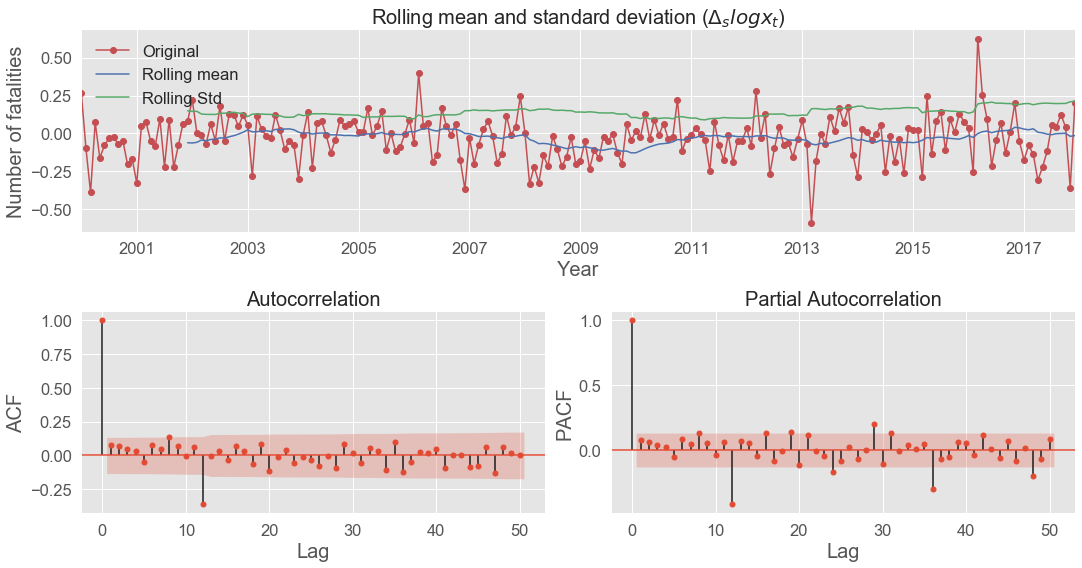

Test statistic: -5.0885597273002166
p-value: 1.4780883903309482e-05
Critial Values (1%): -3.462818
Critial Values (5%): -2.875815
Critial Values (10%): -2.574379


In [27]:
plot_ts(ts.fatalities_log_sdiff.dropna(), title = 'Rolling mean and standard deviation ($\Delta_s log x_t$)',
        nlags = 50)

From the ACF and partial ACF plots, we can make the following observations:

1. The ACF is negative and statistically significant at lag 12. In other words, the serial correlation is different from zero at the seasonal lag.

2. The partial ACFs are negative and statistically significant at lags 12, 24, 36. 

## G. Combined Regular and Seasonal Differencing of Log Transformed Data

We now compute the combined regular and seasonal diffferencing of the time series and its ACF and partial ACF

In [28]:
ts['fatalities_log_sddiff'] = ts['fatalities_log_sdiff'] - ts['fatalities_log_sdiff'].shift(1)

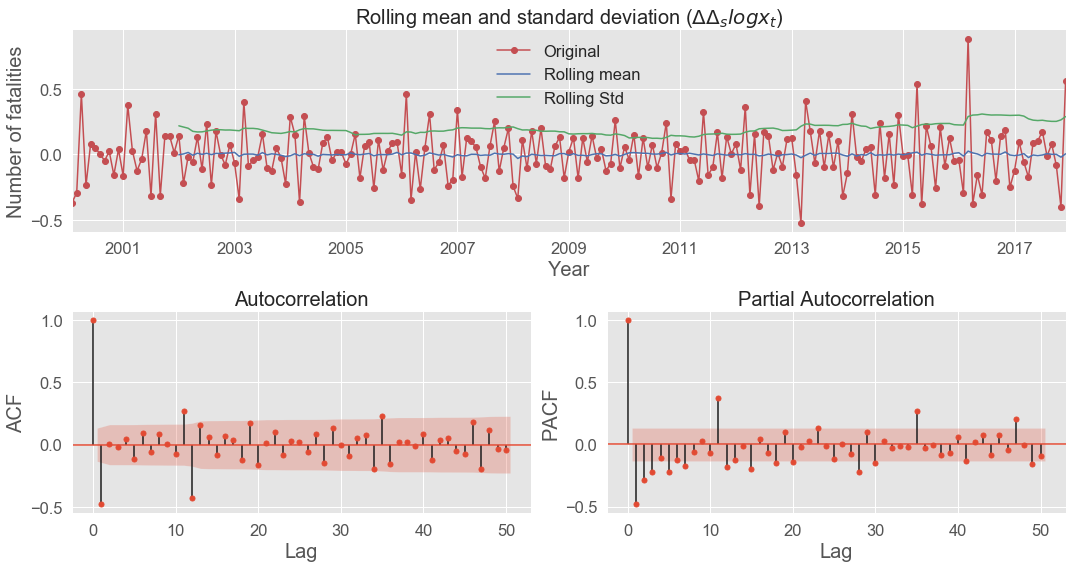

Test statistic: -6.043280890772683
p-value: 1.330178605118768e-07
Critial Values (1%): -3.463476
Critial Values (5%): -2.876102
Critial Values (10%): -2.574532


In [29]:
plot_ts(ts.fatalities_log_sddiff.dropna(), 
        title = 'Rolling mean and standard deviation ($\Delta \Delta_s log x_t$)',
        nlags = 50)

From the plots above, we can identify the orders of the regular and seasonal moving averages. For instance, we can see that the autocorrelation appears to be insignifcant at lags 24 and 36, whereas it has a negative spike at lag 12 after which the seasonal autocorrelation cuts off. This would suggest that the data could be modeled with a moving average model applied to the 12-month period. 

To identify the moving average of the regular time series, we look at patterns between successive months. We see that there is a signifcant autocorrelation a lag 1, after which the autocorrelation seems to cut off. This would indicate a first order moving average for the regular time series.

# 3. Model Fitting and Diagnostic Checking

## A. Training and  Test  Sets


As we saw above, we used the entire observation of the data set to identify the model. However, we would like to show how to use the model to make short-term forecasts. Therefore, we must split the data set into training and test set; we have chosen the test set as the last three year's observations (i.e. 2013-2016).

In [56]:
train_start,train_end = '1999-01-01','2016-12-31'
test_start,test_end = '2017-01-01','2017-12-01'
X_train = ts['fatalities_log'][train_start:train_end].dropna()
X_test = ts['fatalities_log'][test_start:test_end].dropna()

In [57]:
#from pmdarima import auto_arima

In [58]:
#auto_arima(ts['fatalities_log'], seasonal = True, m= 12).summary()

## B. SARIMA Model

We now build a seasonal autoRegressive integrated moving average (SARIMA) regressors model

In [59]:
model = SARIMAX(X_train, trend ='n', order=(0, 1, 1), seasonal_order=(0, 1, 1, 12),
               enforce_stationarity=False, enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     fatalities_log   No. Observations:                  203
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 123.783
Date:                            Mon, 18 Nov 2019   AIC                           -241.565
Time:                                    15:09:58   BIC                           -232.054
Sample:                                02-01-2000   HQIC                          -237.708
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8641      0.038    -22.487      0.000      -0.939      -0.789
ma.S.L12      -0.8456      0.046   

## C. Diagnostic Plots of the Residuals

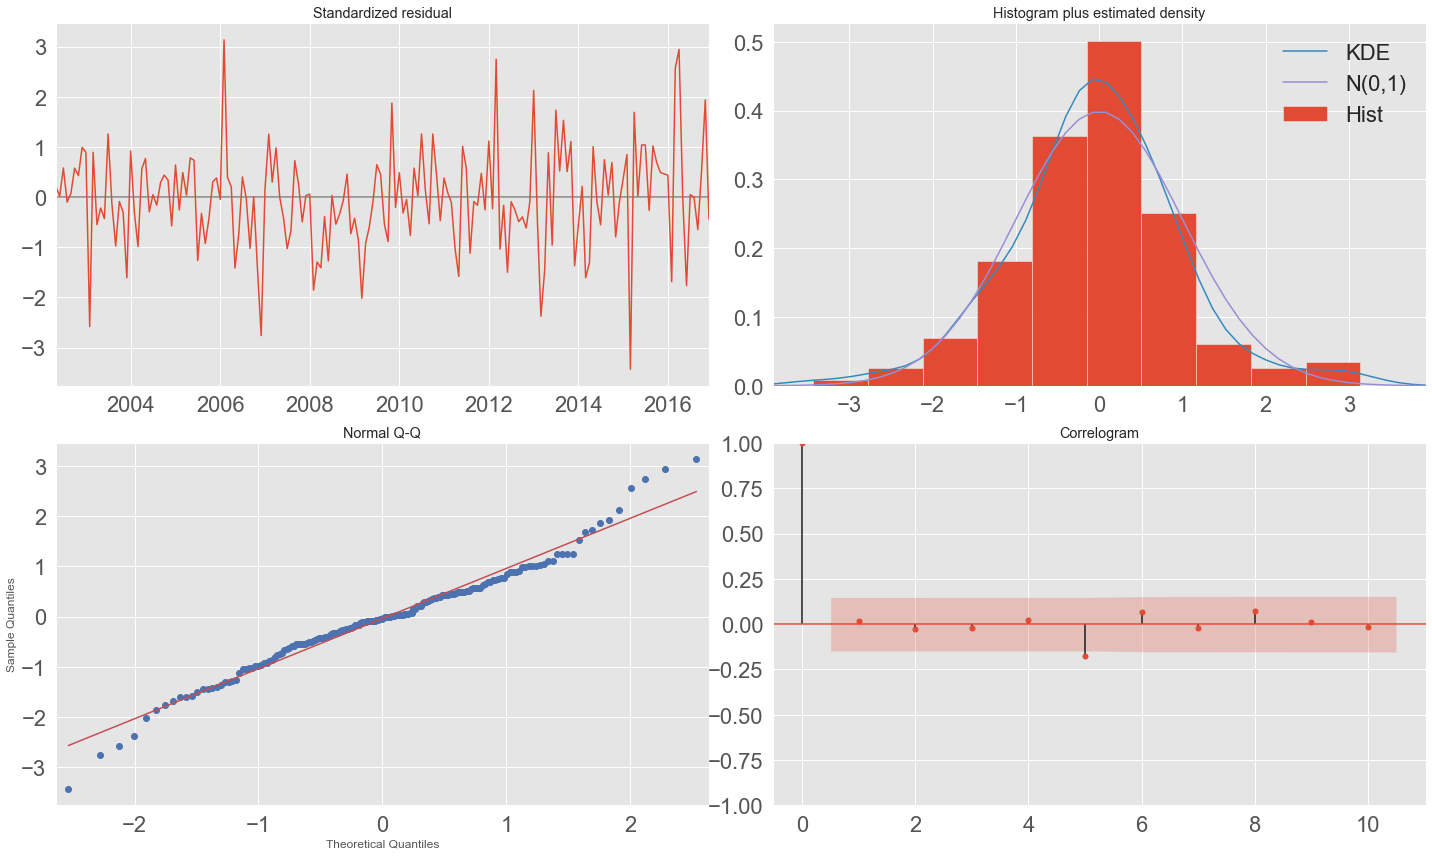

In [60]:
results.plot_diagnostics(figsize=(20,12))
# plt.grid(True)
plt.tight_layout()

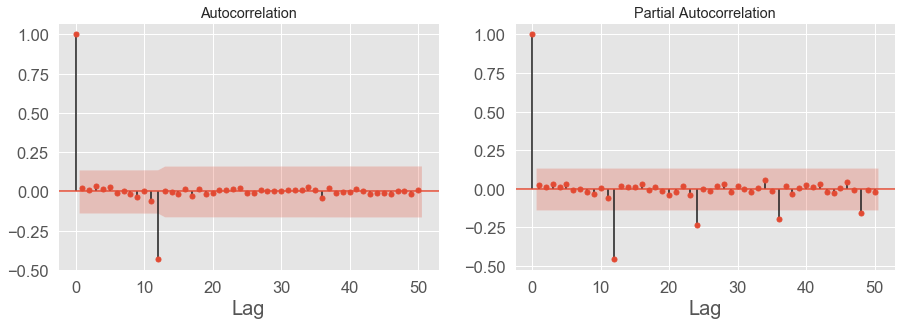

In [61]:
res = results.resid # Residuals

# Set figure and font sizes
sns.set(font_scale = 1.5)
plt.style.use('ggplot')

gridsize = (2, 2)
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid(gridsize, (1, 0))
ax2 = plt.subplot2grid(gridsize, (1, 1))


nlags = 50
# Plot ACF
plot_acf(res, lags = nlags, ax = ax1)
ax1.set_xlabel('Lag', fontsize = 20)
ax1.grid(True)

# Plot PACF
plot_pacf(res, lags = nlags, ax = ax2)
ax2.set_xlabel('Lag', fontsize = 20)
ax2.grid(True)
plt.show()

From the above residual analysis, we see that the model looks good up to lag 10 beyond which the ACF and partial ACF develop a spike at the season lag, 12. 

Below, we look at other self-made  diagnostic plots of the residuals

Text(0, 0.5, 'Residual')

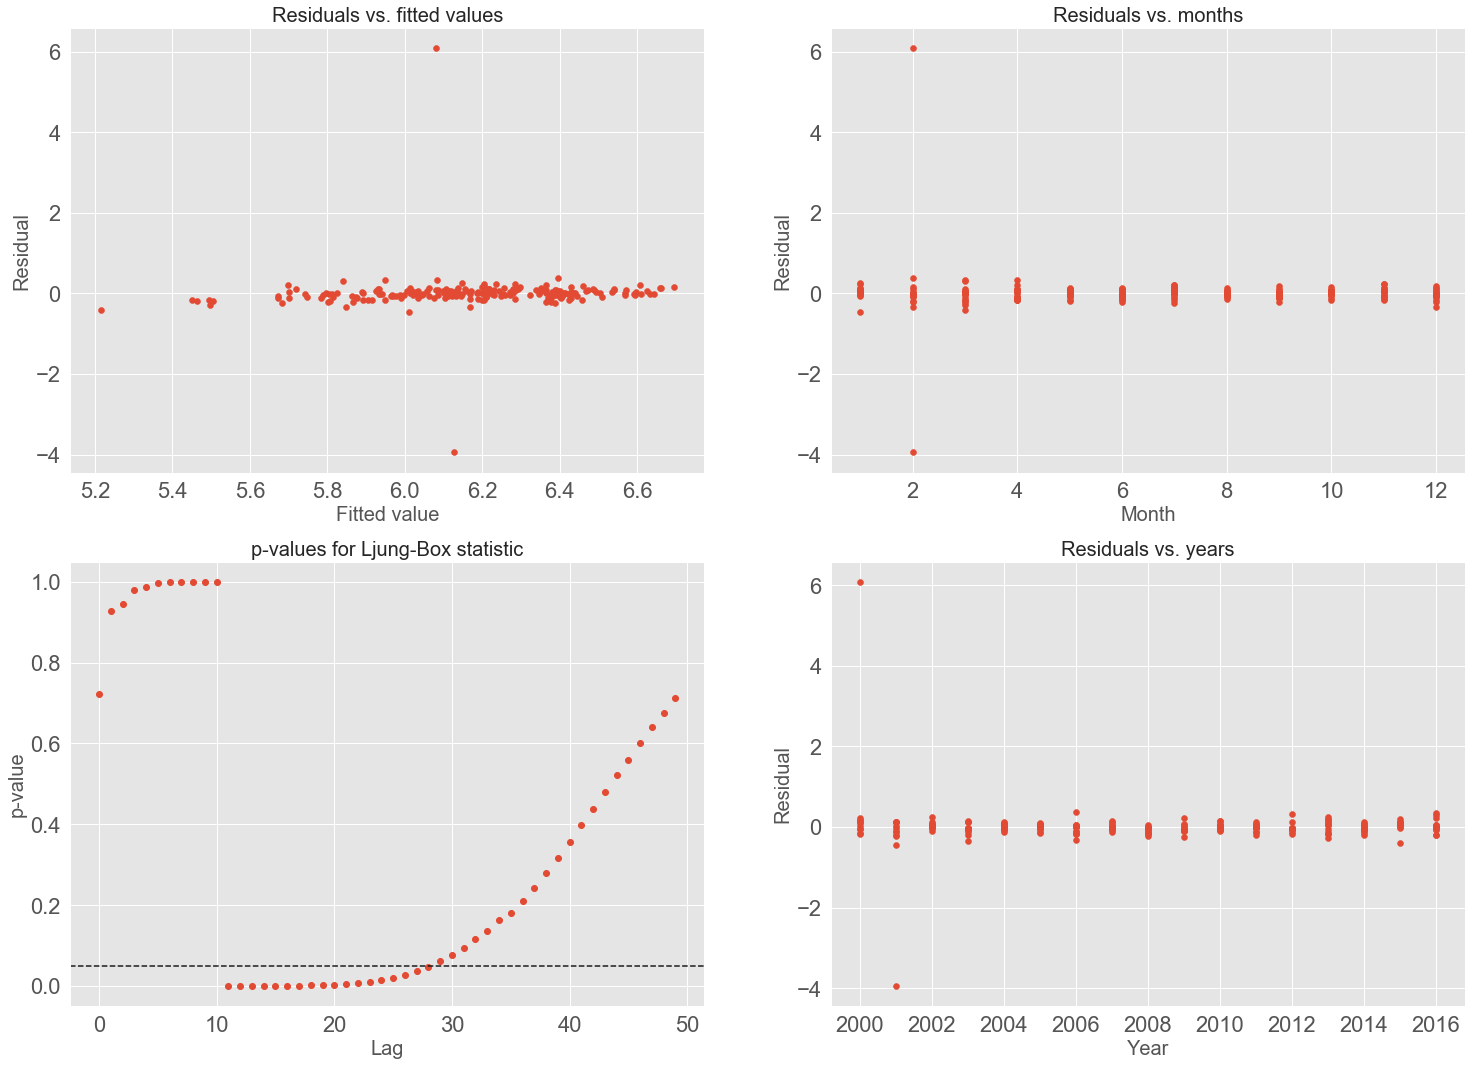

In [62]:
# Set figure size
gridsize = (2,2)

fig = plt.subplots(figsize = (25,18))
sns.set(font_scale = 2)
plt.style.use('ggplot')

ax1 = plt.subplot2grid(gridsize, (0,0))
ax2 = plt.subplot2grid(gridsize, (0,1))
ax3 = plt.subplot2grid(gridsize, (1,0))
ax4 = plt.subplot2grid(gridsize, (1,1))

# Make plots
ax1.scatter(X_train.values, res.values)
ax2.scatter(X_train.index.month, res.values)
ax3.plot(acorr_ljungbox(res.values, lags = 50)[1], 'o')
ax3.axhline(y=0.05,linestyle= '--', color = 'k')
ax4.scatter(X_train.index.year, res.values)

# Plot labels
ax1.set_xlabel('Fitted value', fontsize = 20)
ax1.set_title('Residuals vs. fitted values', fontsize = 20)
ax1.set_ylabel('Residual', fontsize = 20)
ax2.set_xlabel('Month', fontsize = 20)
ax2.set_ylabel('Residual', fontsize = 20)
ax2.set_title('Residuals vs. months', fontsize = 20)
ax3.set_xlabel('Lag', fontsize = 20)
ax3.set_ylabel('p-value', fontsize = 20)
ax3.set_title('p-values for Ljung-Box statistic', fontsize = 20)
ax4.set_xlabel('Year', fontsize = 20)
ax4.set_title('Residuals vs. years', fontsize = 20)
ax4.set_ylabel('Residual', fontsize = 20)

From the above diagnostic plots, we see that something unusual happened in January 1999 and 2000 due to significant outliers. A careful inspection of the data shows that most fatal collision happpned in those years. The plot of the p-value vs. lag of the Ljung–Box Q test shows a discontinuity at lag 12. The model seems to work best up to lag 10 as we noted above.  We  have also tried other transformations and models but nothing seems to do a better job than the model we've have built. In the following, we now make forecast based on the SARIMAX model.

## Model Prediction on the Test Set

In [63]:
X_pred = results.predict(test_start,test_end)

In [64]:
df_af = pd.DataFrame({'Actual':np.exp(X_test),'Predicted':np.exp(X_pred), 'Residual':np.exp(X_test-X_pred)})
df_af

,Actual,Predicted,Residual
2017-01-01,315.0,370.665952,0.849822
2017-02-01,218.0,286.039280,0.762133
2017-03-01,300.0,280.161892,1.070809
2017-04-01,281.0,290.380539,0.967696
2017-05-01,290.0,352.959774,0.821623
2017-06-01,294.0,384.012388,0.765600
2017-07-01,529.0,496.577465,1.065292
2017-08-01,508.0,484.884123,1.047673
2017-09-01,446.0,418.957041,1.064548
2017-10-01,464.0,426.304376,1.088424


## Model Performance

In [74]:
r2 = r_squared(df_af.Actual, df_af.Predicted)
MAE = mae(df_af.Actual, df_af.Predicted)
RMSE = rmse(df_af.Actual, df_af.Predicted)

print('MAE = {}, RMSE = {}, R^2 = {}'.format(round(MAE,3), round(RMSE,3), round(r2,3)))

MAE = 47.433, RMSE = 53.54, R^2 = 0.718


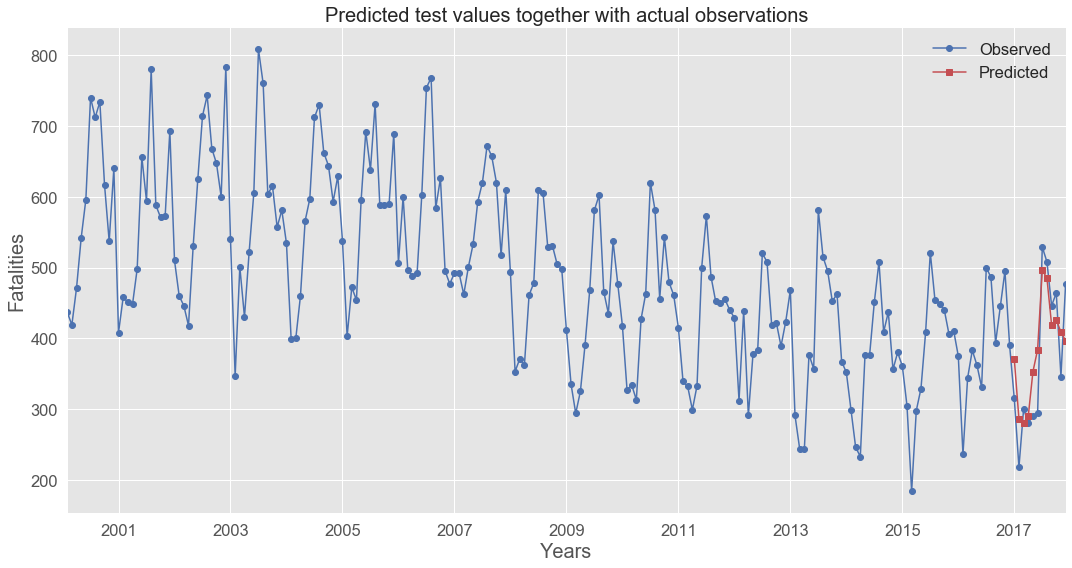

In [85]:
sns.set(font_scale = 1.5)
plt.style.use('ggplot')

ts['fatalities'].plot(figsize=(15,8), marker = 'o', color = 'b')
df_af['Predicted'].plot(figsize=(15,8), marker = 's', color = 'r')
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Fatalities', fontsize = 20)
plt.title('Predicted test values together with actual observations', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.legend(['Observed', 'Predicted'])

We see that predicted test values relatively captured the actual test values, however the prediction suffers immensely from extreme outliers, therefore the model can be improved by resolving this isssue.

#  Forecasting

We now make a one year forecast and plot the forecasted values alongside the original data

In [41]:
model = SARIMAX(ts['fatalities'],order=(0, 1, 1), seasonal_order=(0, 1, 1, 12),
               enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(ts['fatalities']),len(ts['fatalities'])+12).rename('SARIMA(0,1,1)(0,1,1,12) Forecast')

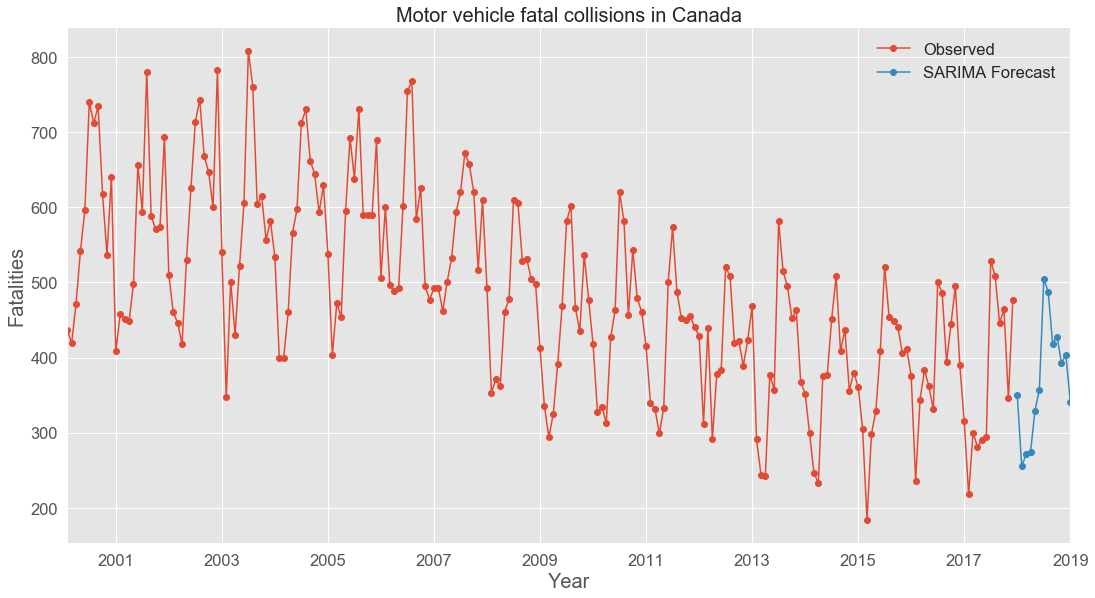

In [84]:
ts['fatalities'].plot(marker = 'o',figsize=(15,8))
fcast.plot(marker = 'o')

plt.tight_layout()
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Fatalities', fontsize = 20)
plt.title('Motor vehicle fatal collisions in Canada', fontsize = 20)
plt.legend(['Observed', 'SARIMA Forecast'])